In [1]:
import numpy as np
import pprint
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import advertools as adv
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,  cross_val_predict
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
pp = pprint.PrettyPrinter(indent=4, sort_dicts=False)

#### Loading the data into dataframes and doing light preprocessing 

In [2]:
def preprocess(data):
    data.text = data.text.apply(lambda x: x.lower())
    data.text = data.text.replace(r'\s+|\\n', ' ', regex=True)
    return data


train_data = pd.read_csv("data/train_data.csv")
train_data = preprocess(train_data)
print(train_data.head())


test_data = pd.read_csv("data/test_data.csv")
test_data = preprocess(test_data)
print(test_data.head())


  language                                               text    label
0    dansk   dette er et fremragende initiativ, og jeg stø...  Ireland
1    dansk   hr. formand, jeg er sikker på, at alle her er...  Ireland
2    dansk   hr. formand, folk på den nordlige halvkugle t...  England
3    dansk   hr. formand, med forbehold af nogle få ændrin...  England
4    dansk   - hr. formand, jeg må protestere mod den lemf...  England
                                                text
0   hr. formand, selv om vi i høj grad sympatiser...
1   quiero dejar constancia de mi apoyo a este in...
2   . – el comercio ilegal de riñones humanos se ...
3   signor presidente, per introdurre una nota di...
4   jeg stemte for meddelelsen af decharge til fæ...


In [3]:
train_data = train_data[pd.notnull(train_data["text"])]
train_data["category_id"] = train_data["label"].astype("category")
train_data["category_id"] = train_data["category_id"].cat.codes
train_data["lang_id"] = train_data["language"].astype("category")
train_data["lang_id"] = train_data["lang_id"].cat.codes
train_data.head()

category_id_df = train_data[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)


In [4]:
import advertools as adv
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = []
for key in ["danish", "german", "dutch", "italian", "spanish"]:
    stop_words += list(adv.stopwords[key])


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words=stop_words)
features = tfidf.fit_transform(train_data.text)
lang_labels = train_data.lang_id
labels = train_data.category_id

test_bow = tfidf.transform(test_data.text)


In [5]:
# # Random Undersampling
# us = RandomUnderSampler(random_state=21)
# features, labels = us.fit_resample(features, labels)

# # Random Oversampling
# os = RandomOverSampler(random_state=21)
# features, labels= os.fit_resample(features, labels)

# # SMOTE
# os = SMOTE(random_state=21)
# features, labels= os.fit_resample(features, labels)

In [6]:
model = LinearSVC(max_iter=5000, random_state=21, C=1,  penalty="l1", dual=False, class_weight="balanced")

model.fit(features, labels)
predicted_labels = model.predict(test_bow)

In [7]:
final_data = {"id": test_data.index+1, "label": predicted_labels}

submission = pd.DataFrame(data=final_data).set_index("id")
submission = submission.label.apply(lambda x: id_to_category[x])
submission.to_csv("submissions/submission_SVM.csv")
submission.head()


id
1     England
2    Scotland
3     England
4     Ireland
5    Scotland
Name: label, dtype: object

{   'Model': 'LinearSVC',
    'Train': {   'Training Accuracy scores': array([0.95245971, 0.95086601, 0.95182824, 0.95131706, 0.94843036]),
                 'Mean Training Accuracy': 95.09802742362281,
                 'Training Precision scores': array([0.94756832, 0.94544194, 0.94667146, 0.94604731, 0.94243348]),
                 'Mean Training Precision': 0.9456325022850244,
                 'Training Recall scores': array([0.95040542, 0.94861334, 0.94990104, 0.94967023, 0.94685948]),
                 'Mean Training Recall': 0.9490899029135285,
                 'Training F1 scores': array([0.94896929, 0.94701082, 0.9482671 , 0.94783753, 0.94461378]),
                 'Mean Training F1 Score': 0.9473397041617782},
    'Test': {   'Validation Accuracy scores': array([0.73550637, 0.73947558, 0.74933847, 0.74681261, 0.74440702]),
                'Mean Validation Accuracy': 74.31080105845561,
                'Validation Precision scores': array([0.70807385, 0.71546083, 0.72607209, 0.7223

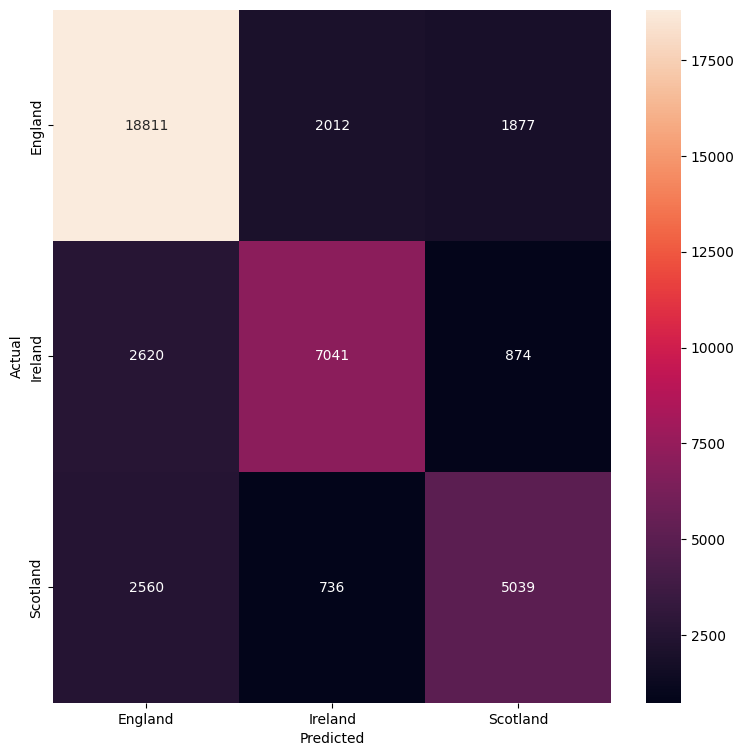

              precision    recall  f1-score   support

     Ireland       0.78      0.83      0.81     22700
     England       0.72      0.67      0.69     10535
    Scotland       0.65      0.60      0.62      8335

    accuracy                           0.74     41570
   macro avg       0.72      0.70      0.71     41570
weighted avg       0.74      0.74      0.74     41570



In [8]:
X = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=21)
_scoring = {'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
            'f1': make_scorer(f1_score, average='macro')
            }
kfold = KFold(n_splits=5, shuffle=True, random_state=21)
results = cross_validate(model, features, labels, scoring=_scoring, cv=kfold, return_train_score=True)
pp.pprint({"Model": type(model).__name__,
            "Train": {
           "Training Accuracy scores": results['train_accuracy'],
           "Mean Training Accuracy": results['train_accuracy'].mean()*100,
           "Training Precision scores": results['train_precision'],
           "Mean Training Precision": results['train_precision'].mean(),
           "Training Recall scores": results['train_recall'],
           "Mean Training Recall": results['train_recall'].mean(),
           "Training F1 scores": results['train_f1'],
           "Mean Training F1 Score": results['train_f1'].mean(),
            },
            "Test": {
           "Validation Accuracy scores": results['test_accuracy'],
           "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
           "Validation Precision scores": results['test_precision'],
           "Mean Validation Precision": results['test_precision'].mean(),
           "Validation Recall scores": results['test_recall'],
           "Mean Validation Recall": results['test_recall'].mean(),
           "Validation F1 scores": results['test_f1'],
           "Mean Validation F1 Score": results['test_f1'].mean()
           }})

y_pred = cross_val_predict(model, features, labels, cv=kfold)
conf_mat = confusion_matrix(labels, y_pred)
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(labels, y_pred, target_names=train_data['label'].unique()))